In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import seaborn as sns


In [2]:
labels_dataframe = pd.read_csv('train.csv')
labels_dataframe.head(5)

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [3]:
labels_dataframe.describe()


,image,label
count,18353,18353
unique,18353,176
top,images/0.jpg,maclura_pomifera
freq,1,353


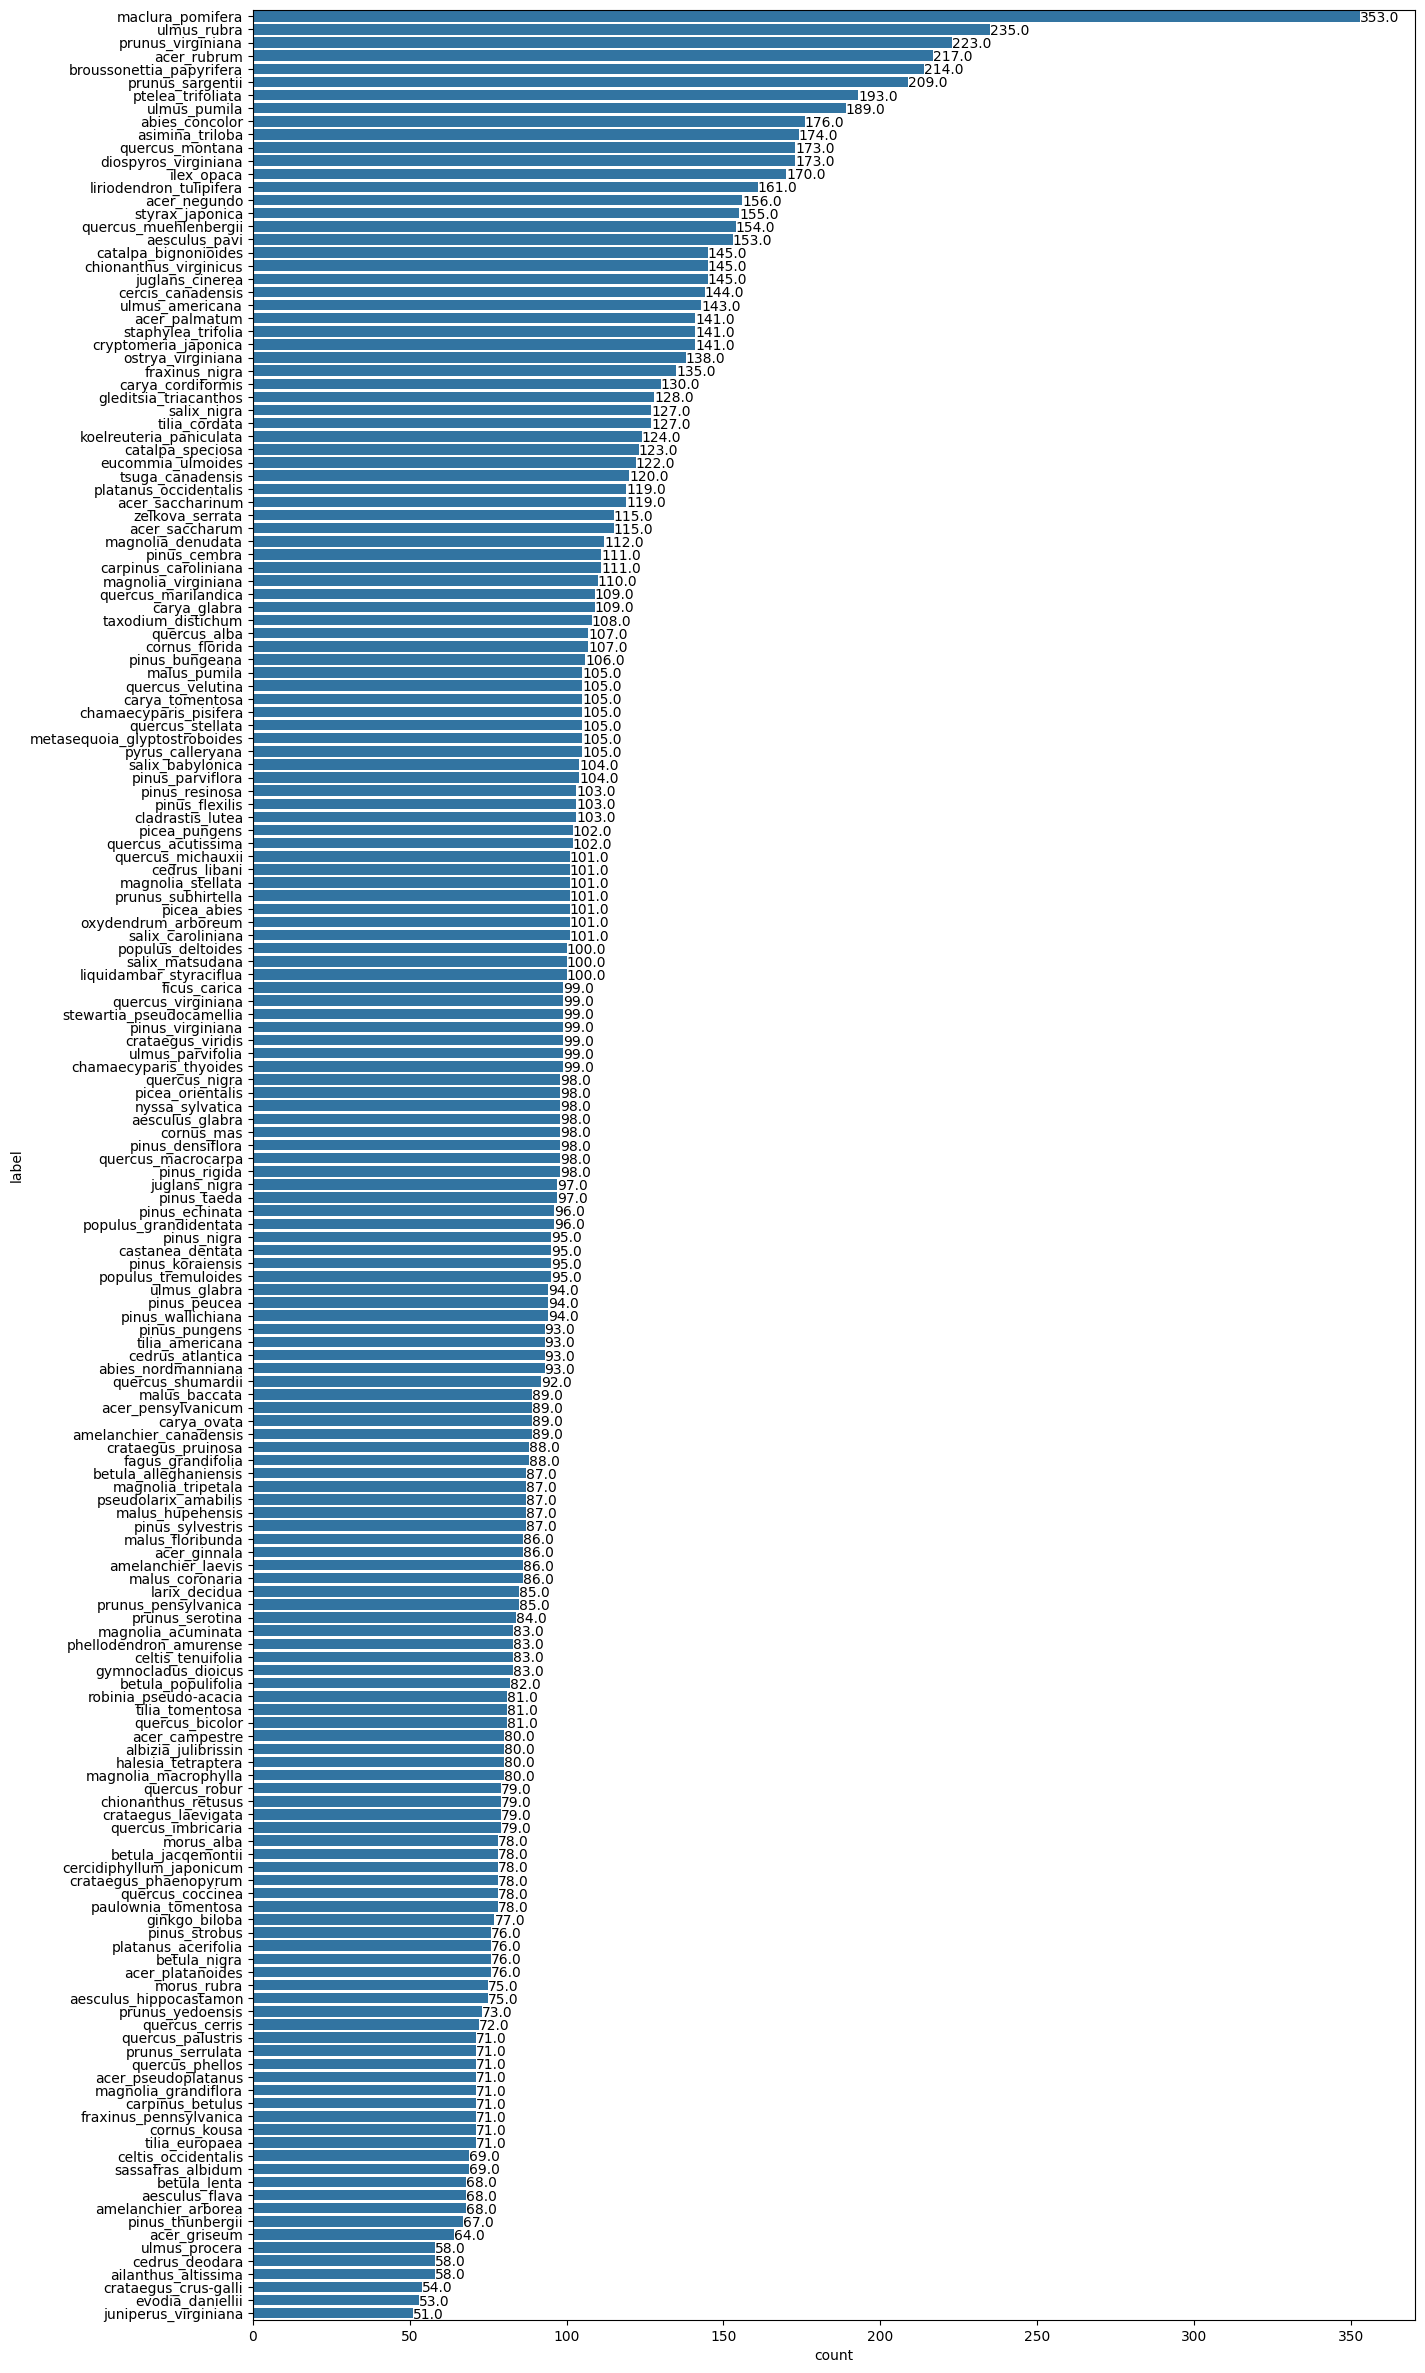

In [4]:
def barw(ax):
    for p in ax.patches:
        val = p.get_width()
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(round(val, 2),(x, y))


plt.figure(figsize = (15, 30))
ax0 = sns.countplot(y = labels_dataframe['label'], order = labels_dataframe['label'].value_counts().index)
barw(ax0)
plt.show()
           

In [5]:
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
leaves_labels[:10]

176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [6]:
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [7]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}

In [8]:
num_to_class

{0: 'abies_concolor',
 1: 'abies_nordmanniana',
 2: 'acer_campestre',
 3: 'acer_ginnala',
 4: 'acer_griseum',
 5: 'acer_negundo',
 6: 'acer_palmatum',
 7: 'acer_pensylvanicum',
 8: 'acer_platanoides',
 9: 'acer_pseudoplatanus',
 10: 'acer_rubrum',
 11: 'acer_saccharinum',
 12: 'acer_saccharum',
 13: 'aesculus_flava',
 14: 'aesculus_glabra',
 15: 'aesculus_hippocastamon',
 16: 'aesculus_pavi',
 17: 'ailanthus_altissima',
 18: 'albizia_julibrissin',
 19: 'amelanchier_arborea',
 20: 'amelanchier_canadensis',
 21: 'amelanchier_laevis',
 22: 'asimina_triloba',
 23: 'betula_alleghaniensis',
 24: 'betula_jacqemontii',
 25: 'betula_lenta',
 26: 'betula_nigra',
 27: 'betula_populifolia',
 28: 'broussonettia_papyrifera',
 29: 'carpinus_betulus',
 30: 'carpinus_caroliniana',
 31: 'carya_cordiformis',
 32: 'carya_glabra',
 33: 'carya_ovata',
 34: 'carya_tomentosa',
 35: 'castanea_dentata',
 36: 'catalpa_bignonioides',
 37: 'catalpa_speciosa',
 38: 'cedrus_atlantica',
 39: 'cedrus_deodara',
 40: 'c

In [9]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * (1 - valid_ratio))
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        

        #设置好需要转换的变量
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [10]:

train_path = './train.csv'
test_path = './test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = './'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
print(train_dataset)
print(val_dataset)
print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [11]:
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=8, 
        shuffle=False,
       
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=8, 
        shuffle=False,
        
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8, 
        shuffle=False,
        
    )

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif getattr (torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_default_device()
print(device)

mps


In [13]:
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

In [14]:
# 超参数
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 50
model_path = './pre_res_model.ckpt'

In [15]:
# Initialize a model, and put it on the device specified.
model = res_model(176)
model = model.to(device)
model.device = device
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

# The number of training epochs.
n_epochs = num_epoch

best_acc = 0.0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))

/Users/meinv/Documents/GitHub/cangku/python_learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meinv/Documents/GitHub/cangku/python_learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1836/1836 [05:04<00:00,  6.02it/s]


[ Train | 001/050 ] loss = 2.88059, acc = 0.29684


100%|██████████| 459/459 [00:16<00:00, 27.03it/s]


[ Valid | 001/050 ] loss = 1.79966, acc = 0.46705
saving model with acc 0.467


100%|██████████| 1836/1836 [04:48<00:00,  6.37it/s]


[ Train | 002/050 ] loss = 1.64791, acc = 0.52669


100%|██████████| 459/459 [00:16<00:00, 27.87it/s]


[ Valid | 002/050 ] loss = 1.83273, acc = 0.49047
saving model with acc 0.490


100%|██████████| 1836/1836 [04:47<00:00,  6.38it/s]


[ Train | 003/050 ] loss = 1.26480, acc = 0.63045


100%|██████████| 459/459 [00:17<00:00, 26.77it/s]


[ Valid | 003/050 ] loss = 1.28408, acc = 0.62173
saving model with acc 0.622


100%|██████████| 1836/1836 [04:47<00:00,  6.39it/s]


[ Train | 004/050 ] loss = 1.03558, acc = 0.69744


100%|██████████| 459/459 [00:16<00:00, 28.07it/s]


[ Valid | 004/050 ] loss = 1.38251, acc = 0.59286


100%|██████████| 1836/1836 [04:46<00:00,  6.41it/s]


[ Train | 005/050 ] loss = 0.88150, acc = 0.74094


100%|██████████| 459/459 [00:16<00:00, 28.07it/s]


[ Valid | 005/050 ] loss = 0.99538, acc = 0.70398
saving model with acc 0.704


100%|██████████| 1836/1836 [04:47<00:00,  6.38it/s]


[ Train | 006/050 ] loss = 0.76272, acc = 0.77730


100%|██████████| 459/459 [00:16<00:00, 27.59it/s]


[ Valid | 006/050 ] loss = 1.06360, acc = 0.69608


100%|██████████| 1836/1836 [04:44<00:00,  6.45it/s]


[ Train | 007/050 ] loss = 0.67326, acc = 0.80433


100%|██████████| 459/459 [00:16<00:00, 28.46it/s]


[ Valid | 007/050 ] loss = 0.86973, acc = 0.73393
saving model with acc 0.734


100%|██████████| 1836/1836 [04:44<00:00,  6.46it/s]


[ Train | 008/050 ] loss = 0.60238, acc = 0.82632


100%|██████████| 459/459 [00:16<00:00, 28.14it/s]


[ Valid | 008/050 ] loss = 1.20412, acc = 0.64570


100%|██████████| 1836/1836 [12:12<00:00,  2.51it/s]    


[ Train | 009/050 ] loss = 0.55242, acc = 0.84484


100%|██████████| 459/459 [00:16<00:00, 28.10it/s]


[ Valid | 009/050 ] loss = 0.85872, acc = 0.74346
saving model with acc 0.743


100%|██████████| 1836/1836 [04:51<00:00,  6.31it/s]


[ Train | 010/050 ] loss = 0.51003, acc = 0.85778


100%|██████████| 459/459 [00:16<00:00, 27.84it/s]


[ Valid | 010/050 ] loss = 0.75006, acc = 0.77342
saving model with acc 0.773


100%|██████████| 1836/1836 [04:48<00:00,  6.36it/s]


[ Train | 011/050 ] loss = 0.46510, acc = 0.87275


100%|██████████| 459/459 [00:17<00:00, 26.13it/s]


[ Valid | 011/050 ] loss = 0.79528, acc = 0.77070


100%|██████████| 1836/1836 [04:49<00:00,  6.35it/s]


[ Train | 012/050 ] loss = 0.44506, acc = 0.87847


100%|██████████| 459/459 [00:16<00:00, 27.04it/s]


[ Valid | 012/050 ] loss = 0.77642, acc = 0.77614
saving model with acc 0.776


100%|██████████| 1836/1836 [04:48<00:00,  6.37it/s]


[ Train | 013/050 ] loss = 0.41763, acc = 0.88719


100%|██████████| 459/459 [00:16<00:00, 27.20it/s]


[ Valid | 013/050 ] loss = 0.88311, acc = 0.74183


100%|██████████| 1836/1836 [04:48<00:00,  6.36it/s]


[ Train | 014/050 ] loss = 0.39791, acc = 0.89250


100%|██████████| 459/459 [00:17<00:00, 26.79it/s]


[ Valid | 014/050 ] loss = 0.79275, acc = 0.77097


100%|██████████| 1836/1836 [04:50<00:00,  6.33it/s]


[ Train | 015/050 ] loss = 0.38014, acc = 0.89971


100%|██████████| 459/459 [00:16<00:00, 27.08it/s]


[ Valid | 015/050 ] loss = 0.71315, acc = 0.78486
saving model with acc 0.785


100%|██████████| 1836/1836 [04:49<00:00,  6.34it/s]


[ Train | 016/050 ] loss = 0.35420, acc = 0.90897


100%|██████████| 459/459 [00:16<00:00, 27.16it/s]


[ Valid | 016/050 ] loss = 0.77561, acc = 0.77832


100%|██████████| 1836/1836 [04:59<00:00,  6.14it/s]


[ Train | 017/050 ] loss = 0.34746, acc = 0.91033


100%|██████████| 459/459 [00:17<00:00, 26.96it/s]


[ Valid | 017/050 ] loss = 0.78569, acc = 0.77342


100%|██████████| 1836/1836 [04:50<00:00,  6.33it/s]


[ Train | 018/050 ] loss = 0.33803, acc = 0.91374


100%|██████████| 459/459 [00:16<00:00, 27.25it/s]


[ Valid | 018/050 ] loss = 1.27438, acc = 0.70697


100%|██████████| 1836/1836 [04:46<00:00,  6.42it/s]


[ Train | 019/050 ] loss = 0.32098, acc = 0.91973


100%|██████████| 459/459 [00:16<00:00, 27.21it/s]


[ Valid | 019/050 ] loss = 1.06327, acc = 0.71705


100%|██████████| 1836/1836 [04:47<00:00,  6.38it/s]


[ Train | 020/050 ] loss = 0.31680, acc = 0.92048


100%|██████████| 459/459 [00:16<00:00, 27.38it/s]


[ Valid | 020/050 ] loss = 0.79715, acc = 0.77288


100%|██████████| 1836/1836 [04:46<00:00,  6.41it/s]


[ Train | 021/050 ] loss = 0.30393, acc = 0.92361


100%|██████████| 459/459 [00:16<00:00, 27.32it/s]


[ Valid | 021/050 ] loss = 0.82183, acc = 0.76879


100%|██████████| 1836/1836 [04:46<00:00,  6.40it/s]


[ Train | 022/050 ] loss = 0.30249, acc = 0.92722


100%|██████████| 459/459 [00:16<00:00, 27.31it/s]


[ Valid | 022/050 ] loss = 0.78064, acc = 0.78023


100%|██████████| 1836/1836 [04:47<00:00,  6.39it/s]


[ Train | 023/050 ] loss = 0.29394, acc = 0.92633


100%|██████████| 459/459 [00:16<00:00, 27.32it/s]


[ Valid | 023/050 ] loss = 0.98706, acc = 0.73339


100%|██████████| 1836/1836 [04:46<00:00,  6.40it/s]


[ Train | 024/050 ] loss = 0.28353, acc = 0.93342


100%|██████████| 459/459 [00:16<00:00, 27.32it/s]


[ Valid | 024/050 ] loss = 0.86333, acc = 0.75980


100%|██████████| 1836/1836 [04:50<00:00,  6.33it/s]


[ Train | 025/050 ] loss = 0.27888, acc = 0.93158


100%|██████████| 459/459 [00:16<00:00, 27.03it/s]


[ Valid | 025/050 ] loss = 0.80469, acc = 0.76688


100%|██████████| 1836/1836 [04:49<00:00,  6.34it/s]


[ Train | 026/050 ] loss = 0.27685, acc = 0.93362


100%|██████████| 459/459 [00:17<00:00, 26.92it/s]


[ Valid | 026/050 ] loss = 0.81774, acc = 0.77832


100%|██████████| 1836/1836 [04:49<00:00,  6.34it/s]


[ Train | 027/050 ] loss = 0.27336, acc = 0.93199


100%|██████████| 459/459 [00:18<00:00, 25.49it/s]


[ Valid | 027/050 ] loss = 0.70367, acc = 0.81345
saving model with acc 0.813


100%|██████████| 1836/1836 [04:49<00:00,  6.35it/s]


[ Train | 028/050 ] loss = 0.25380, acc = 0.94261


100%|██████████| 459/459 [00:17<00:00, 26.96it/s]


[ Valid | 028/050 ] loss = 0.72939, acc = 0.79630


100%|██████████| 1836/1836 [04:48<00:00,  6.35it/s]


[ Train | 029/050 ] loss = 0.26298, acc = 0.94070


100%|██████████| 459/459 [00:16<00:00, 27.03it/s]


[ Valid | 029/050 ] loss = 0.74741, acc = 0.78676


100%|██████████| 1836/1836 [04:49<00:00,  6.35it/s]


[ Train | 030/050 ] loss = 0.26486, acc = 0.93573


100%|██████████| 459/459 [00:17<00:00, 26.93it/s]


[ Valid | 030/050 ] loss = 0.85616, acc = 0.77097


100%|██████████| 1836/1836 [04:49<00:00,  6.35it/s]


[ Train | 031/050 ] loss = 0.23883, acc = 0.94458


100%|██████████| 459/459 [00:16<00:00, 27.08it/s]


[ Valid | 031/050 ] loss = 0.82907, acc = 0.77288


100%|██████████| 1836/1836 [04:48<00:00,  6.35it/s]


[ Train | 032/050 ] loss = 0.25044, acc = 0.94179


100%|██████████| 459/459 [00:17<00:00, 26.99it/s]


[ Valid | 032/050 ] loss = 0.71179, acc = 0.79820


100%|██████████| 1836/1836 [04:48<00:00,  6.36it/s]


[ Train | 033/050 ] loss = 0.24339, acc = 0.94356


100%|██████████| 459/459 [00:16<00:00, 27.05it/s]


[ Valid | 033/050 ] loss = 0.66048, acc = 0.80746


100%|██████████| 1836/1836 [04:59<00:00,  6.12it/s]


[ Train | 034/050 ] loss = 0.24028, acc = 0.94649


100%|██████████| 459/459 [00:17<00:00, 26.36it/s]


[ Valid | 034/050 ] loss = 0.71397, acc = 0.79221


100%|██████████| 1836/1836 [05:02<00:00,  6.08it/s]


[ Train | 035/050 ] loss = 0.24072, acc = 0.94410


100%|██████████| 459/459 [00:17<00:00, 25.97it/s]


[ Valid | 035/050 ] loss = 0.69233, acc = 0.79956


100%|██████████| 1836/1836 [05:02<00:00,  6.07it/s]


[ Train | 036/050 ] loss = 0.23561, acc = 0.94751


100%|██████████| 459/459 [00:17<00:00, 26.02it/s]


[ Valid | 036/050 ] loss = 0.83717, acc = 0.76743


100%|██████████| 1836/1836 [05:02<00:00,  6.07it/s]


[ Train | 037/050 ] loss = 0.23514, acc = 0.94737


100%|██████████| 459/459 [00:17<00:00, 25.96it/s]


[ Valid | 037/050 ] loss = 0.72318, acc = 0.80202


100%|██████████| 1836/1836 [05:01<00:00,  6.10it/s]


[ Train | 038/050 ] loss = 0.22383, acc = 0.95118


100%|██████████| 459/459 [00:17<00:00, 26.41it/s]


[ Valid | 038/050 ] loss = 0.73525, acc = 0.78186


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 039/050 ] loss = 0.22535, acc = 0.95214


100%|██████████| 459/459 [00:17<00:00, 26.37it/s]


[ Valid | 039/050 ] loss = 0.69873, acc = 0.80392


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 040/050 ] loss = 0.21950, acc = 0.95234


100%|██████████| 459/459 [00:17<00:00, 26.34it/s]


[ Valid | 040/050 ] loss = 0.73983, acc = 0.78758


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 041/050 ] loss = 0.21874, acc = 0.95282


100%|██████████| 459/459 [00:17<00:00, 26.45it/s]


[ Valid | 041/050 ] loss = 0.74180, acc = 0.79194


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 042/050 ] loss = 0.21758, acc = 0.95227


100%|██████████| 459/459 [00:17<00:00, 26.32it/s]


[ Valid | 042/050 ] loss = 0.80335, acc = 0.77778


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 043/050 ] loss = 0.22677, acc = 0.94989


100%|██████████| 459/459 [00:17<00:00, 26.02it/s]


[ Valid | 043/050 ] loss = 0.67278, acc = 0.81046


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 044/050 ] loss = 0.20031, acc = 0.95752


100%|██████████| 459/459 [00:17<00:00, 26.29it/s]


[ Valid | 044/050 ] loss = 0.74361, acc = 0.79657


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 045/050 ] loss = 0.21536, acc = 0.95357


100%|██████████| 459/459 [00:17<00:00, 26.37it/s]


[ Valid | 045/050 ] loss = 0.67536, acc = 0.81073


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 046/050 ] loss = 0.21002, acc = 0.95438


100%|██████████| 459/459 [00:17<00:00, 26.35it/s]


[ Valid | 046/050 ] loss = 1.02466, acc = 0.73121


100%|██████████| 1836/1836 [05:00<00:00,  6.10it/s]


[ Train | 047/050 ] loss = 0.18949, acc = 0.96235


100%|██████████| 459/459 [00:17<00:00, 26.29it/s]


[ Valid | 047/050 ] loss = 0.58247, acc = 0.83252
saving model with acc 0.833


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 048/050 ] loss = 0.21501, acc = 0.95541


100%|██████████| 459/459 [00:17<00:00, 26.33it/s]


[ Valid | 048/050 ] loss = 0.72993, acc = 0.79085


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 049/050 ] loss = 0.21422, acc = 0.95425


100%|██████████| 459/459 [00:17<00:00, 26.24it/s]


[ Valid | 049/050 ] loss = 0.83742, acc = 0.78295


100%|██████████| 1836/1836 [05:00<00:00,  6.11it/s]


[ Train | 050/050 ] loss = 0.19885, acc = 0.95956


100%|██████████| 459/459 [00:17<00:00, 26.43it/s]

[ Valid | 050/050 ] loss = 0.83660, acc = 0.77696


In [24]:
saveFileName = './submission.csv'

In [25]:
## predict
model = res_model(176)

# create model and load weights from checkpoint
model = model.to(device)
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    
    imgs = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    
    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")

/Users/meinv/Documents/GitHub/cangku/python_learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/meinv/Documents/GitHub/cangku/python_learning/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/bv/yrtwvfc92bnc90b_s89_h8280000gn/T/ipykernel_29810/1070240556.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data w

Done!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [26]:
!kaggle competitions submit -c classify-leaves -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 295k/295k [00:02<00:00, 115kB/s]
Successfully submitted to Classify Leaves